# Barotropic velocity

In [2]:
%run ../_setup.py

import math
import numpy as np
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

from netCDF4 import Dataset, num2date

from OceanPy.interpolation import OI

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook


In [3]:
# load adcp and ctd data
input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_adcp.nc')
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')

adcp = Dataset(input_file_adcp)
ctd = Dataset(input_file_ctd)

# format times with timestamp
time_adcp = num2date(adcp['time'][:], adcp['time'].units)
time_ctd = num2date(ctd['time'][:], ctd['time'].units)

# calculate mean of the adcp velocities based on the time interval 
# that the ctd was overboard
nst, npl = ctd.dimensions['profile'].size, adcp.dimensions['plevel'].size
utmean, vtmean = np.ma.masked_all((nst, npl)), np.ma.masked_all((nst, npl))
lonmean, latmean = np.ma.masked_all((nst,)), np.ma.masked_all((nst,))
for ist, tctd in enumerate(time_ctd):
    it = [it for it, tadcp in enumerate(time_adcp) if tctd[0] <= tadcp < tctd[1]]
    if len(it):
        utmean[ist,] = np.nanmean(adcp['u'][it], axis=0)
        vtmean[ist,] = np.nanmean(adcp['v'][it], axis=0)
        lonmean[ist,] = np.nanmean(adcp['lon'][it])
        latmean[ist,] = np.nanmean(adcp['lat'][it])
            
# find index of pressure closest to predefined pressure level
plevel = 100
pressure = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size-2)
ip = (np.abs(pressure-plevel)).argmin()

# calculate mean of velocities from surface to pressure level
utdmean = np.nanmean(utmean[:, slice(0, ip)], axis=1)
vtdmean = np.nanmean(vtmean[:, slice(0, ip)], axis=1)

# calculate magnitude of vectors and calculate standard deviation
vmag = np.sqrt(utmean[:, slice(0, ip)]**2 + vtmean[:, slice(0, ip)]**2)
vmagstd = np.nanstd(vmag, axis=1)



In [4]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p']):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1500
p_int = 1000

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# find finite values
idx = np.isfinite(D[2:])

# # interpolate (using Optimal Interpolation) dynamic height contours on grid
# lon, lat = ctd['lon'][2:, 0][idx], ctd['lat'][2:, 0][idx]
# xx, yy, dhb, dha = OI(lon, lat, D[2:][idx], L=(lon.max() - lon.min())/5)

# interpolate linearly dynamic height contours on grid
lon, lat = ctd['lon'][2:, 0][idx], ctd['lat'][2:, 0][idx]
nx, ny = 20, 20
xi = np.linspace(lon.min(), lon.max(), nx)
yi = np.linspace(lat.min(), lat.max(), ny)
xx, yy = np.meshgrid(xi, yi)
Dgrd = griddata((lon, lat), D[2:][idx], (xx, yy), method='linear')



(-52.5, -48)

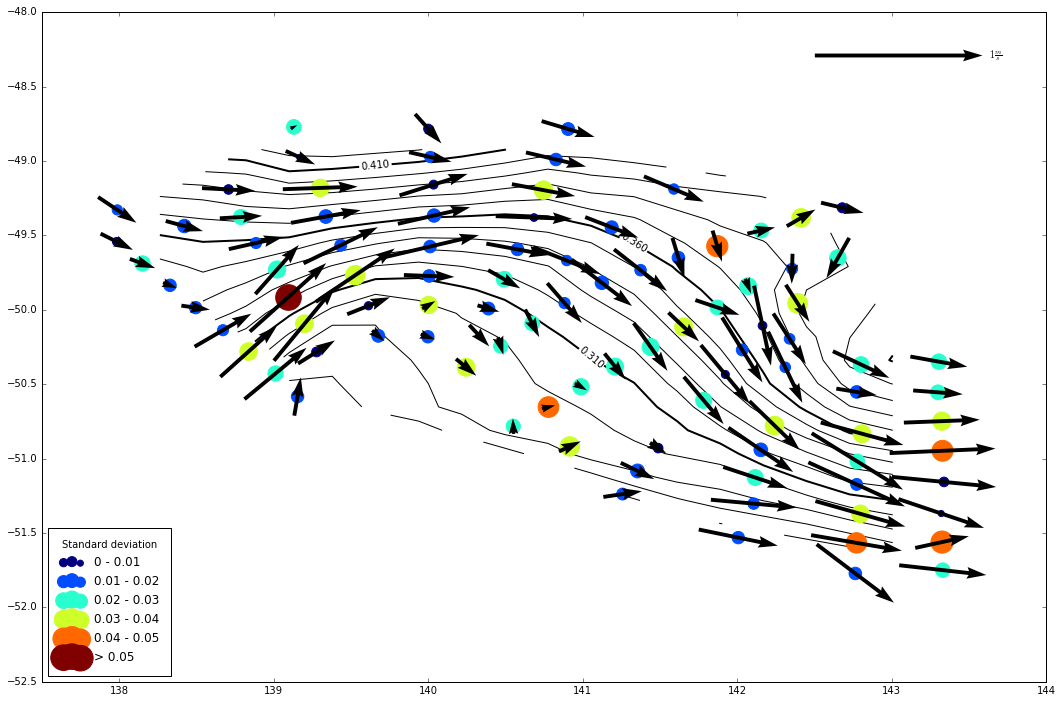

In [6]:
# PLOT

fig, ax = plt.subplots(figsize=(18, 12))

# plot dynamic height contours
step = 0.01
xmin, xmax = math.floor(np.nanmin(Dgrd)*100)/100, math.ceil(np.nanmax(Dgrd)*100)/100
nsteps = int((xmax - xmin) / step) + 2
bounds = np.linspace(xmin, xmax, nsteps)

ct = ax.contour(xx, yy, Dgrd, bounds, colors='k', zorder=-1)

for ib, b in enumerate(bounds):
    if b in bounds[::5]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(ct, bounds[0::5], inline=1, fontsize=10)


# plot quiver plot
Q = ax.quiver(lonmean[2:], latmean[2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*18, zorder=2)
qk = plt.quiverkey(Q, 0.85, 0.85, 1, r'$1 \frac{m}{s}$', labelpos='E', coordinates='figure')

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = cm.jet(np.linspace(0, 1, 6))
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (vmagstd[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (vmagstd[2:] > std_bins[i]) & (vmagstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(lonmean[2:][criteria], latmean[2:][criteria], s=vmagstd[2:][criteria]*1e4, 
               label=label, color=colors[i], zorder=1)
ax.legend(title='Standard deviation', borderpad=1, fontsize='large', loc=3)

ax.set_xlim([137.5, 144])
ax.set_ylim([-52.5, -48])
